# Custom Grid World 
### BY FLYN SEQUEIRA - 1001778678 - Reinforcement Learning
- State Space: [row_position, col_position, orientation]
- Actions: ["Forward", "Backward", "Turn left", "Turn Right"]
- Environment has information such as Barriers, Start State, Goal State
- Reaching Goal State rewards you with 100 points
- Not moving at all results in -100 reward
- Else you get a reward of 100 points

## DynaQ Learning Algorithm 
- DynaQ Reinforcement Learning algorithm was successfully implemented in this environment, and the output of the technique clearly demonstrates the benifit of offline learning resulting in learning in online with much lesser episodes

## Prioritized Sweeping Algorithm
- Still under implementation, and would be expected to learn faster than DynaQ algorithm overall.

#### LEARNING REFERENCES 
1. https://dbader.org/blog/priority-queues-in-python
2. https://towardsdatascience.com/reinforcement-learning-model-based-planning-methods-extension-572dfee4cceb
3. https://medium.com/@ranko.mosic/online-planning-agent-dyna-q-algorithm-and-dyna-maze-example-sutton-and-barto-2016-7ad84a6dc52b
4. http://incompleteideas.net/book/first/ebook/node98.html



In [90]:
import numpy as np
import sys
import gym
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from queue import PriorityQueue

# Custom Grid World

In [92]:
class CustomGridWorld():

    def __init__(self, rows, cols, obstacles=[], start_state = (0,0,0), goal_state=(0,0), orientation_success = 0.9, move_success = 0.8):
        self.grid = np.ones((rows,cols))
        self.obstacles = obstacles
        
#         Row and column that the bot can exist in (to handle the starting state)
        self.r = list(range(self.grid.shape[0]))
        self.c = list(range(self.grid.shape[1]))
        for obstacle_r, obstacle_c in obstacles:
            try: self.r.remove(obstacle_r)
            except: pass
            try: self.c.remove(obstacle_c)
            except: pass
        
        
        for row,col in obstacles:
            self.grid[row,col]=0
        if self.grid[start_state[0],start_state[1]]!=1:
            return None
        self.state = list(start_state)
        self.goal = goal_state
        self.actions = ["turn_left","turn_right","forward","backward"]
        self.nA = len(self.actions)
        
#         Setting up orientation movement =======================================
        self.all_orientations = ["up","left","down","right"]
        self.orientation_action = {
            "turn_left": 0,
            "turn_right": 1
        }
        
#         CURRENT ORIENTATION ===================================================
        self.orientation = self.all_orientations[start_state[2]]
        
#         ACTION ORIENTATION ====================================================
#         Example: to move left you just do the following
#         self.orientation = self.orientation_movement[self.orientation]=self.move_left
        self.orientation_movement = {
            "up": ["left", "right"],
            "left": ["down", "up"],
            "down": ["right", "left"],
            "right": ["up", "down"]
        }
        
#         Setting up forward backward ===========================================
#         forward[option]=(row_change, column_change)
#         to get backward you negate the forward solution
        self.forward = {
            "up":np.array([-1,0]),
            "left":np.array([0,-1]),
            "down":np.array([1,0]),
            "right": np.array([0,1])
        }
        self.move_success_likelihood = move_success
        self.change_orientation_success_likelihood = orientation_success
    
#     ACTION OF CHANGING DIRECTION===============================================
    def change_orientation(self,direction):
#        dir: "turn_left" or "turn_right"
#         DESIGN FOR WHEN FAIL
#         print('path 1')
#         if(str(type(self.state))=="<class 'str'>"):
#             print('1')
        if(type(direction)==int):
            direction = self.actions.index(direction)
            
        success = self.change_orientation_success_likelihood
        change = np.random.choice([True, False], 1, p=[success, 1-success])
        if change[0]:
#         WHEN SUCCESSFUL
            self.orientation = self.orientation_movement[self.orientation][self.orientation_action[direction]]
            self.state[2] = self.all_orientations.index(self.orientation)
        return self.state

    
#     ACTION OF CHANGING MOVING FRONT OR BACK====================================
    def move(self, direction):
#         dir: "forward" or "backward"
#         return new_state
#         print('path 3')
#         if(str(type(self.state))=="<class 'str'>"):
#             print('3')
        success = self.move_success_likelihood
        change = np.random.choice([True, False], 1, p=[success, 1-success])
        if change[0]:
#               WHEN SUCCESSFUL
            flag = 1 if direction == "forward" else -1
#               FLAG would be -1 if direction is backward, and the result is the same as -1*forward
            displacement = flag*self.forward[self.orientation]
#             print(displacement)
            self.state[0] += displacement[0]
            self.state[1] += displacement[1]
#               If you went outside row border or col border or hit a roadblock
            if(self.state[0]<0 or self.state[1]<0 or self.state[0]>=self.grid.shape[0] or self.state[1]>=self.grid.shape[1] or self.grid[self.state[0],self.state[1]]==0):
                self.state[0] -= displacement[0]
                self.state[1] -= displacement[1]
        return self.state
    
#     RESET ENVIRONMENT BY PUTTING THE BOT IN A RANDOMIZED POSITION =============
    def reset(self):
#         print('path 2')
#         if(str(type(self.state))=="<class 'str'>"):
#             print('2')
        uniform_r = np.ones(len(self.r))
        uniform_prob_r = uniform_r/sum(uniform_r)
        uniform_c = np.ones(len(self.c))
        uniform_prob_c = uniform_c/sum(uniform_c)
        self.state = [
            np.random.choice(self.r, 1, p=uniform_prob_r)[0], 
            np.random.choice(self.c, 1, p=uniform_prob_c)[0],
            np.random.choice([0,1,2,3], 1, p=[0.25,0.25,0.25,0.25])[0]
        ]
        return str(self.state)
    
    
#     ACTION GENERALIZED --- FOR CONVINIENCE?
    def step(self, direction):
#         print('path 4')
#         if(str(type(self.state))=="<class 'str'>"):
#             print('4')
        old_state = self.state
        if (str(type(direction))=="<class 'numpy.int64'>" or type(direction)==int):
            direction = self.actions[direction]
        if(direction in ["forward", "backward"]):
            self.state = self.move(direction)
        else:
            self.state = self.change_orientation(direction)
        done = self.isGoal()
        if old_state == self.state:
            reward = -100
        elif done:
            reward = 100
        else:
            reward = 0
        return str(self.state), reward, done
    def isGoal(self):
#         print('path 5')
#         if(str(type(self.state))=="<class 'str'>"):
#             print('5')
        if self.state[0]==self.goal[0] and self.state[1]==self.goal[1]:
            return True
        else:
            return False

In [93]:
def performAction(env,state, Q, epsilon):
# PERFORMS ACTION ONLINE
#     Epsilon greedy method
    choices = [True, False]
    explore = np.random.choice(choices, 1, p=[epsilon, 1-epsilon])[0]
    if explore:
        distr_prep = np.ones(env.nA)
        prob_distr = distr_prep/np.sum(distr_prep)
        legalActions = list(range(env.nA))
        return np.random.choice(legalActions, 1, p=prob_distr)[0]
    else:
        return np.argmax(Q[state])

# Dyna Q Learning
1. simulate_Q function -> Part of the code that learns offline
2. dyna_q_learning -> The main code that performs the dynamic Q learning
> When variable offline_count = 0, it is a simple Q learning with no offline learning taking place

In [94]:
def simulate_Q(Q, observations, model, offline_count = 10, alpha=0.1, gamma=1.0):
#     Q, Tc, Rc, T, offline_count = 100, alpha=0.1, gamma=1.0
#   Build Model
    for _ in range(offline_count):
#       Select an action for state env.reset()
        observation = observations[np.random.choice(range(len(observations)))]
        state,action = observation.split('-')
        next_state, reward = model[observation][np.random.choice(range(len(model[observation])))]

#         UPDATE Q VALUE ================================================================================
#         state, action = state_action_sample.split('-')
        action=int(action)
#         next_state = str(next_state_sample)
#         next_state = env.step(action)
        next_action = int(np.argmax(Q[next_state]))
        
#         p = (alpha * (r_s_a_sbar + (gamma * Q[next_state][next_action]) - Q[state][action]))
        Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
        
#         SEND RESULTING Q BACK =========================================================================
    return Q

In [101]:
def dyna_q_learning(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05):
    for offline_count in [0, 40, 80]:
        # initialize action-value function (empty dictionary of arrays)
        Q = defaultdict(lambda: np.zeros(env.nA))
        # initialize performance monitor -
    #     Get a0 for s0 based on epsilon
        plot_every = num_episodes/25
        # loop over episodes
        score_collection = []
        scores = []
    #     COUNTER INITIATED
        Tc = {}
        Rc = {}
        T = {}
        observations = set()
        model = defaultdict(list)
        tot_steps = 0
        for i_episode in range(1, num_episodes+1):
            episode_reward = 0
    #         How it acts in each episode
            state = env.reset()
            action = performAction(env,state,Q,epsilon)
            done = False
            steps = 0
            while not done:
                steps+=1
                next_state, reward, done = env.step(action)
                episode_reward += reward
                if not done:
                    next_action = performAction(env,next_state,Q,epsilon)
                    Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
    #                 observation = str(state)+'-'+str(action)+'-'+str(next_state)
                    ob = str(state)+"-"+str(action)
                    observations.add(ob)
                    model[ob].append((next_state, reward))
    #                 print(Q, list(observations),model, 10, alpha, gamma)
                    Q = simulate_Q(Q, list(observations),model, offline_count = 0, alpha=alpha, gamma=gamma)
                    state = next_state
                    action = next_action
                else:
                    Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
                    score_collection.append(episode_reward)
                    break
    #         print(steps)
            tot_steps+=steps
            # monitor progress
            if i_episode % 10 == 0:
                scores.append(np.mean(score_collection))
                print('\r', 'i_episode: ', i_episode, end='')
                score_collection = []
    #             print('steps in last 10 episode is: ', tot_steps)

    #     plot performance
        plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
        plt.xlabel('Episode Number')
        plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
        plt.show()
        # print best 100-episode performance
        print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))

    return Q

In [102]:
obstacles = [(0,14),(1,14),(2,14),(3,14),(4,14),(5,14),(6,14),(7,14),(8,14),(9,14),(10,14),(11,14),(12,14),(12,14),(13,14)]
env = CustomGridWorld(15,25, obstacles, (0, 0, 0), (4,4), 0.9, 0.8)

# RESULTS
1. The results are shown for offline steps = 0, 40 and 80

 i_episode:  1000

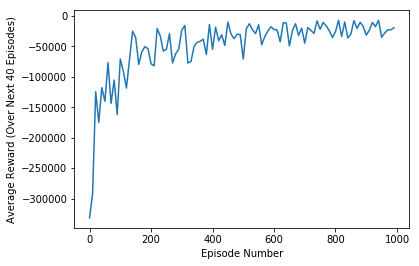

Best Average Reward over 40 Episodes:  -7120.0
 i_episode:  1000

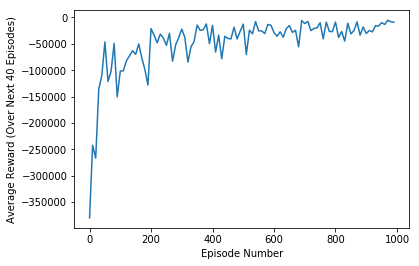

Best Average Reward over 40 Episodes:  -5260.0
 i_episode:  1000

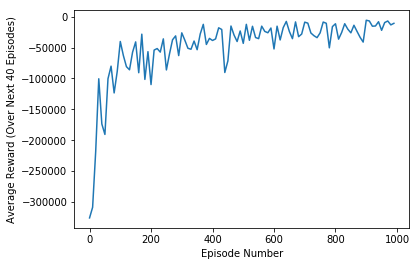

Best Average Reward over 40 Episodes:  -5650.0


In [104]:
# env = CustomGridWorld(15,25, [], (0, 0, 0), (4,4), 0.9, 0.8)
q = dyna_q_learning(env, num_episodes=1000, alpha=0.2, gamma=0.8, epsilon=0.05)

In [100]:
def priorityQueueLearning(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05, treshold=5):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor -
#     Get a0 for s0 based on epsilon
    plot_every = num_episodes/25
    # loop over episodes
    score_collection = []
    scores = []
#     COUNTER INITIATED
    Tc = {}
    Rc = {}
    T = {}
#     observations = set()
    queue = PriorityQueue()
    model = defaultdict(list)
    predecessors = defaultdict(list)
    tot_steps = 0
    for i_episode in range(1, num_episodes+1):
        episode_reward = 0
#         How it acts in each episode
        state = env.reset()
        action = performAction(env,state,Q,epsilon)
        done = False
        steps = 0
        while not done:
            steps+=1
            next_state, reward, done = env.step(action)
            episode_reward += reward
            if not done:
                next_action = performAction(env,next_state,Q,epsilon)
                Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
                p = np.absolute(reward + np.max(list(Q[next_state].values())) - Q[state][action])
                
#                 HANDLE PREDECESSOR
                predecessors[next_state].append((state, action))
                state = next_state
                ob = str(state)+"-"+str(action)
            
                if p > treshold:
                    queue.put((p, ob))
                    
                model[ob].append((next_state, reward))
#                 print(Q, list(observations),model, 10, alpha, gamma)
                Q, queue, model, predecessors = simulate_p_Q(Q,queue,model, predecessors,theta,offline_count = 10, alpha=alpha, gamma=gamma)
                state = next_state
                action = next_action
            else:
                Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
                score_collection.append(episode_reward)
                break
#         print(steps)
        tot_steps+=steps
        # monitor progress
        if i_episode % 20 == 0:
            scores.append(np.mean(score_collection))
            print('\r', 'i_episode: ', i_episode, end='')
            score_collection = []
#             print('steps in last 10 episode is: ', tot_steps)
        
#     plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
        
    return Q

In [88]:
def simulate_p_Q(Q, queue, model, predecessors, theta, offline_count = 10, alpha=0.1, gamma=1.0):
# def simulate_Q(Q, model, offline_count = 10, alpha=0.1, gamma=1.0):
#     Q, Tc, Rc, T, offline_count = 100, alpha=0.1, gamma=1.0
# HANDLE PREDECESSOR

    for _ in range(offline_count):
        if self.queue.empty():
            break
        
#         observation, reward = model[np.random.choice(range(len(model)))]
        state,action = queue.get()[0].split('-')
        reward, next_state = self.model[state][action]
        Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
        
        
        
        if state not in predecessors.keys():
            continue
        pre_state_action_list = predecessors[state]

        for (pre_state, pre_action) in pre_state_action_list:
            pre_reward, _ = model[pre_state][pre_action]
            pre_tmp_diff = pre_reward + np.max(self.Q[state]) - self.Q_values[pre_state][pre_action]
            if pre_tmp_diff > theta:
                queue.put((-pre_tmp_diff, (pre_state, pre_action)))
        return Q, queue, model, predecessors


In [87]:
# q = priorityQueueLearning(env, num_episodes=500, alpha=0.2, gamma=0.8, epsilon=0.05)

In [44]:
# def ImaginedQValue():
# # initialize action-value function (empty dictionary of arrays)
#     Q = defaultdict(lambda: np.zeros(env.nA))
#     # initialize performance monitor -
# #     Get a0 for s0 based on epsilon
#     plot_every = num_episodes/25
#     # loop over episodes
#     score_collection = []
#     scores = []
    
#     for i_episode in range(1, num_episodes+1):
#         episode_reward = 0
# #         How it acts in each episode
#         state = env.reset()
#         action = performAction(env,state,Q,epsilon)
#         done = False
#         steps = 0
#         while not done:
#             steps+=1
#             next_state, reward, done = env.step(action)

#             episode_reward += reward
# #             list_state = s[1:-1].split(",")
# #             if(int(list_state[1])==10 and int(list_state[0])==10):
# #             print('\r', 'state: ', state,'i: ', i, end='')
#             if not done:
#                 next_action = performAction(env,next_state,Q,epsilon)
#                 Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
#                 model_builder(state, next_state)
#                 state = next_state
#                 action = next_action
#             else:
#                 Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
#                 score_collection.append(episode_reward)
        
                
        
#         # monitor progress
#         if i_episode % 10 == 0:
#             scores.append(np.mean(score_collection))
# #             print("\rEpisode {}/{}: Reward {}".format(i_episode, num_episodes, episode_reward), end="")
# #             sys.stdout.flush()
#             print('\r', 'i_episode: ', i_episode, end='')
#             score_collection = []

In [ ]:
# # https://towardsdatascience.com/reinforcement-learning-model-based-planning-methods-extension-572dfee4cceb
# def priorityQueueLearning(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05, treshold = 5):
#     # initialize action-value function (empty dictionary of arrays)
#     Q = defaultdict(lambda: np.zeros(env.nA))
#     queue = PriorityQueue()
#     # initialize performance monitor -
# #     Get a0 for s0 based on epsilon
#     plot_every = num_episodes/25
#     # loop over episodes
#     score_collection = []
#     scores = []
# #     COUNTER INITIATED
#     Tc = {}
#     Rc = {}
#     T = {}
#     predecessors = defaultdict(list)
#     observations = []
#     tot_steps = 0
#     for i_episode in range(1, num_episodes+1):
#         episode_reward = 0
# #         How it acts in each episode
#         state = env.reset()
#         action = performAction(env,state,Q,epsilon)
#         done = False
#         steps = 0
#         while not done:
#             steps+=1
#             next_state, reward, done = env.step(action)
#             episode_reward += reward
#             if not done:
#                 # update priority queue
#                 p = np.absolute(reward + np.max(list(Q[next_state].values())) - Q[state][action])
#                 if p > treshold:
#                     queue.put(p, (state, action))
#                 observation = str(state)+'-'+str(action)
#                 observations.append((observation, reward))
                
                
# #                 SIMULATION
#                 Q = simulate_p_Q(Q, queue, observations, predecessor, offline_count = 50, alpha=alpha, gamma=gamma)
#             else:
# #                 Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
#                 score_collection.append(episode_reward)
#                 break
#         print(steps)
#         tot_steps+=steps
#         # monitor progress
#         if i_episode % 10 == 0:
#             scores.append(np.mean(score_collection))
#             print('\r', 'i_episode: ', i_episode, end='')
#             score_collection = []
#             print('steps in last 10 episode is: ', tot_steps)
        
# #     plot performance
#     plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
#     plt.xlabel('Episode Number')
#     plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
#     plt.show()
#     # print best 100-episode performance
#     print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
        
#     return Q

In [45]:
def q_learning(env, num_episodes, alpha=0.1, gamma=1.0, epsilon=0.05):
    # initialize action-value function (empty dictionary of arrays)
    Q = defaultdict(lambda: np.zeros(env.nA))
    # initialize performance monitor -
#     Get a0 for s0 based on epsilon
    plot_every = num_episodes/25
    # loop over episodes
    score_collection = []
    scores = []
    for i_episode in range(1, num_episodes+1):
        episode_reward = 0
#         How it acts in each episode
        state = env.reset()
        action = performAction(env,state,Q,epsilon)
        done = False
        while not done:

            next_state, reward, done = env.step(action)
            episode_reward += reward
#             list_state = s[1:-1].split(",")
#             if(int(list_state[1])==10 and int(list_state[0])==10):
#             print('\r', 'state: ', state,'i: ', i, end='')
            if not done:
                next_action = performAction(env,next_state,Q,epsilon)
                Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
                state = next_state
                action = next_action
            else:
                Q[state][action] = Q[state][action] + (alpha * (reward + (gamma * Q[next_state][next_action]) - Q[state][action]))
                score_collection.append(episode_reward)
        
        # monitor progress
        if i_episode % 10 == 0:
            scores.append(np.mean(score_collection))
#             print("\rEpisode {}/{}: Reward {}".format(i_episode, num_episodes, episode_reward), end="")
#             sys.stdout.flush()
            print('\r', 'i_episode: ', i_episode, end='')
            score_collection = []
        ## TODO: complete the function
    
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(scores),endpoint=False),np.asarray(scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(scores))
        
    return Q